# Decision Trees

This notebook implements **decision trees**, a non-parametric supervised learning method that works for both regression and classification tasks. It is a tree-like model of decisions, following a path from the root (node at the top of the tree, acting as the input node for feature vectors in the model) to the leaf (final node where the prediction is made).

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp

# Import functions to make decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text

## The Data

The model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Model 1: Classification Using 2 Predictors (Wing & Tail Length)

I will implement the decision tree for classification tasks. Specifically, I will be continuing with classifying hawk species based on their wing and tail length.

In [48]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
y = hawks["Species"].to_numpy()

# Code the species names numerically for to make decision tree analysis easier
species_nums = {"RT" : 0, "CH" : 1, "SS" : 2}
y_int = np.array(list(map(lambda i : species_nums[i], y)))

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.20, random_state=1)

 As a refresher, below are visualizations of the training and testing set in this aspect. It is clear that we we can formulate boundaries using decision trees to classify a given hawk.

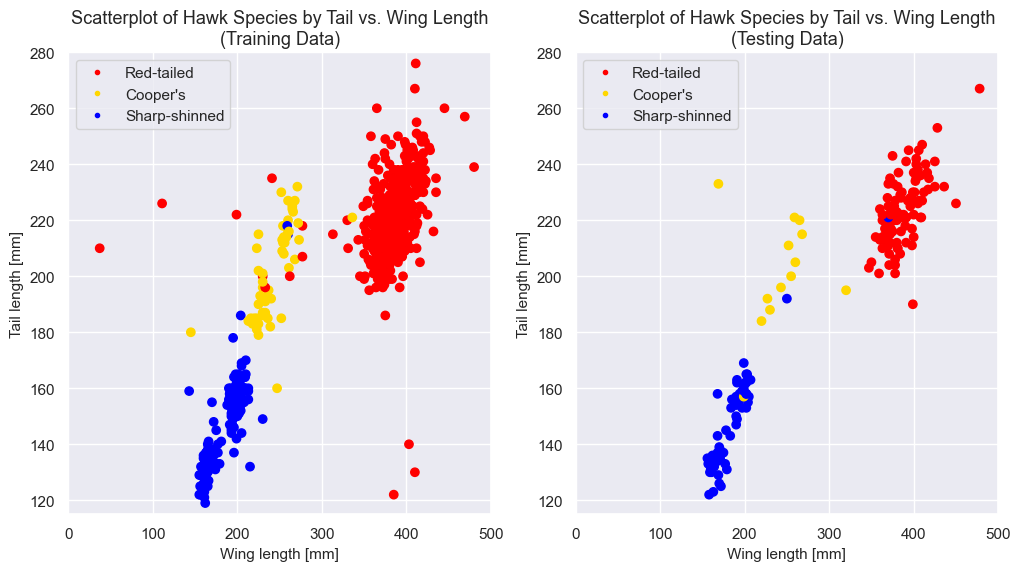

In [49]:
# For color coding points
species_colors = {0: "red", 1: "gold", 2: "blue"}

# For a custom legend
species_names = {0: "Red-tailed", 1: "Cooper's", 2: "Sharp-shinned"}
custom_legend = [Line2D([], [], marker='.', color='red', linestyle='None'),
                 Line2D([], [], marker='.', color='gold', linestyle='None'),
                 Line2D([], [], marker='.', color='blue', linestyle='None')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.set_xlim((0, 500))
ax1.set_ylim((115, 280))
ax1.scatter(X_train[:, 0], X_train[:, 1], color = [species_colors[y] for y in y_train])
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Tail length [mm]", fontsize = 11)
ax1.set_title("Scatterplot of Hawk Species by Tail vs. Wing Length\n(Training Data)", fontsize = 13)
ax1.legend(fontsize = 11, loc = "upper left", handles = custom_legend, labels = species_names.values())

# Plot the testing set
ax2.set_xlim((0, 500))
ax2.set_ylim((115, 280))
ax2.scatter(X_test[:, 0], X_test[:, 1], color = [species_colors[y] for y in y_test])
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Tail length [mm]", fontsize = 11)
ax2.set_title("Scatterplot of Hawk Species by Tail vs. Wing Length\n(Testing Data)", fontsize = 13)
ax2.legend(fontsize = 11, loc = "upper left", handles = custom_legend, labels = species_names.values())
plt.show()

### Training model 1

The scikit-learn library allows for the convenient implementation of the decision tree for classification tasks using `DecisionTreeClassifier`. However, the user must specify what `max_depth` to use. Selecting the correct hyperparameter for this value is crucial so that the model does not overfit or underfit the training data. 

To determine what `max_depth` to proceed with for my data, I iterate over a range of depths and evaluate the training accuracy at each depth. In general, as the depth increases, the training accuracy will increase and then eventually plataeu after being too complex and overfitting the training data. To provide additional insights, I will also factor in the testing data and evaluate the bias-variance breakdown at each depth as well. As the depth increases, the bias of the decision tree will decrease, while the variance would increase.

* __Bias:__  error that arises from incorrect assumptions made by the model about the relationship between the predictors and the response
* __Variance:__ error that arises from the model's sensitivity to small fluctuations in the training data

The optimal value for `max_depth` will balance the bias/variance while leading to the lower overall error.

In [45]:
def plot_tree_performance(X_train, y_train, X_test, y_test):
    """
    Obtain diagnostic plots of the decision tree model's performance over a range of max_depths from 2-20.
    There are two plots: one displaying training accuracy and the other displaying bias/variance.
    This function is meant to help diagnose the best max_depth for a decision tree model for the data.
    """
    # Obtain the accuracy and bias/variance for each Decision Tree to select the best depth
    tree_accuracy = []
    biases = []
    variances = []
    possible_depth = range(2, 21)
    for d in possible_depth:
        tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
        tree_model.fit(X_train, y_train)
        # Obtain the training accuracy of the current decision tree
        tree_accuracy.append(tree_model.score(X_train, y_train))
        # Obtain bias/variance decomposition for the current decision tree
        _, bias, var = bias_variance_decomp(tree_model,
            X_train, y_train, X_test, y_test, loss = 'mse', random_seed = 123)
        biases.append(bias)
        variances.append(var)
    
    # Plot the training accuracy figure on the left
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
    ax1.set_title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
    ax1.set_xlabel('Maximum depth', fontsize = 14)
    ax1.set_ylabel('Classification Accuracy', fontsize = 14)
    ax1.set_xticks(possible_depth)
    # Plot the bias/variance figure on the right
    ax2.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
    ax2.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
    ax2.set_title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
    ax2.set_xlabel('Maximum depth', fontsize = 14)
    ax2.set_xticks(possible_depth)
    ax2.legend(loc = "lower right")

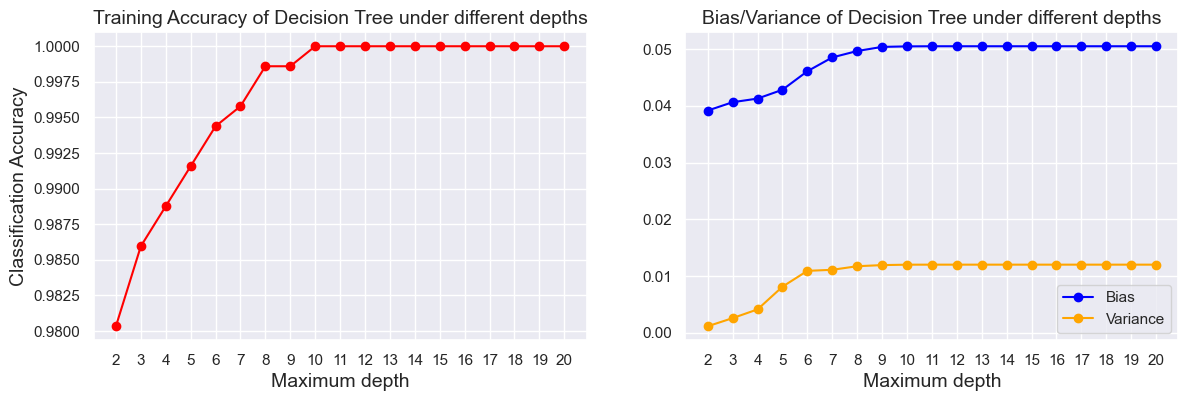

In [46]:
plot_tree_performance(X_train, y_train, X_test, y_test)
plt.show()

Based on the figure of the training accuracies, the optimal `max_depth` would be 8, because beyond this point, increasing the complexity of the model would bring marginal benefits. However, observe at this point, the training accuracy is already exceeding 99%, hinting that there is overfitting. Indeed, based on the bias/variance figure on the right, at `max_depth=8`, the bias/variance have both reached a plateau already.

A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data. Accounting for this, and the curves, I will try `max_depth=3` and `max_depth=6` and determine which of these 2 models is better for classifying hawk species.

### Performance/Error Analysis: Model 1A (max_depth=3)

Now, I will fit a decision tree on the training data using `max_depth=3` and evaluate the model performance more in detail. First, let's look at the decision boundaries.

In [59]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(X_train, y_train)

tree_rules = export_text(decision_tree, feature_names = ["Wing length", "Tail length"])
print(tree_rules, "\n")

|--- Wing length <= 275.00
|   |--- Tail length <= 178.50
|   |   |--- Wing length <= 238.50
|   |   |   |--- class: 2
|   |   |--- Wing length >  238.50
|   |   |   |--- class: 1
|   |--- Tail length >  178.50
|   |   |--- Wing length <= 208.50
|   |   |   |--- class: 0
|   |   |--- Wing length >  208.50
|   |   |   |--- class: 1
|--- Wing length >  275.00
|   |--- Wing length <= 339.50
|   |   |--- Wing length <= 333.50
|   |   |   |--- class: 0
|   |   |--- Wing length >  333.50
|   |   |   |--- class: 1
|   |--- Wing length >  339.50
|   |   |--- Wing length <= 377.50
|   |   |   |--- class: 0
|   |   |--- Wing length >  377.50
|   |   |   |--- class: 0
 



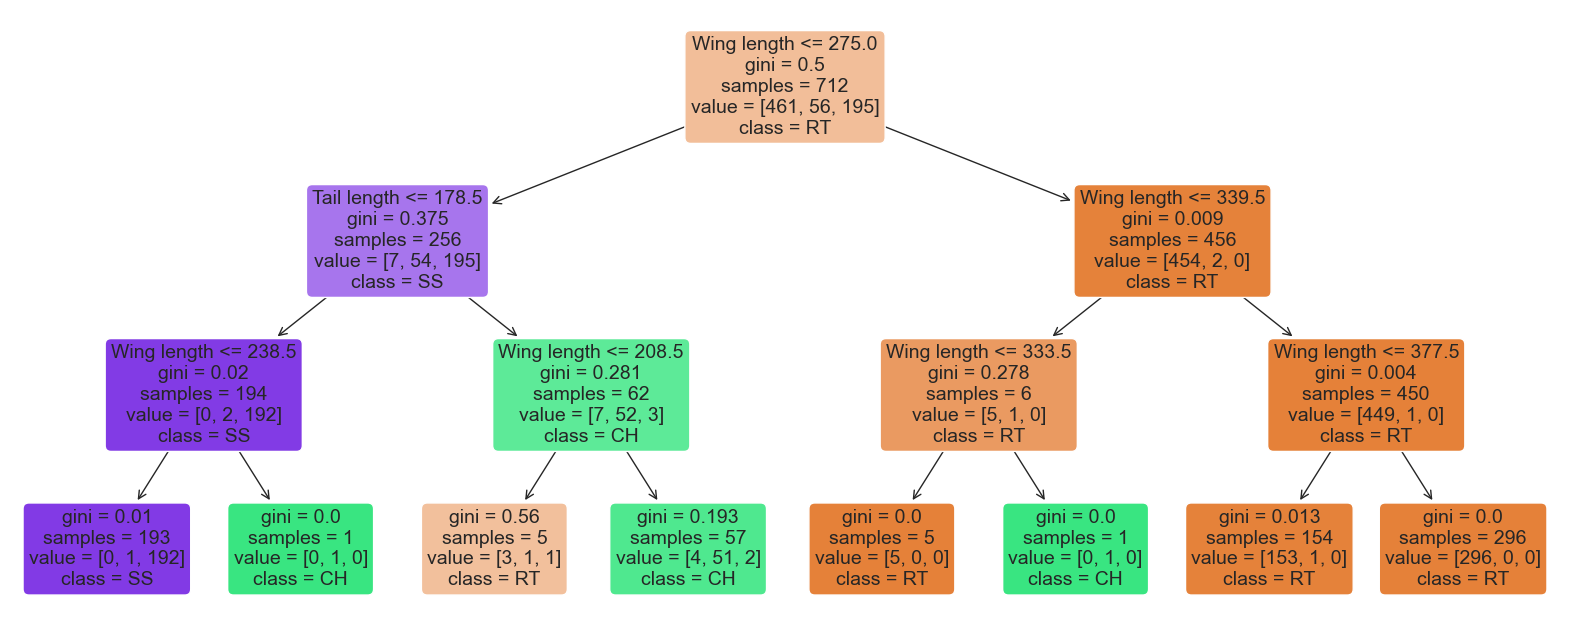

In [60]:
plt.figure(figsize=(20, 8))
a = plot_tree(decision_tree, feature_names = ["Wing length", "Tail length"],
              class_names = ["RT", "CH", "SS"],
              rounded = True, filled = True, fontsize=14)
plt.show()

The leaves of the tree suggest some overfitting may be at play. Notice that there are pairs of leaves where one of the leaves have a low sample count of a class/species. Examination of the decision regions plot confirms this observations.

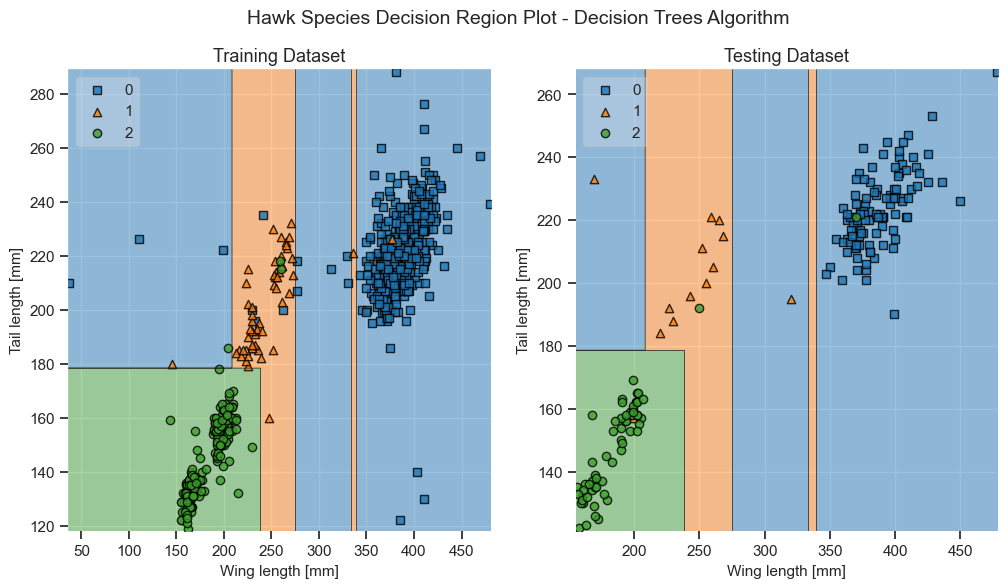

In [61]:
# Plot the training and testing observations with decision regions overlaid
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Hawk Species Decision Region Plot - Decision Trees Algorithm", fontsize = 14)
fig = plot_decision_regions(X_train, y_train, clf = decision_tree, ax = axes[0], legend = 2)
axes[0].set_title("Training Dataset", fontsize = 13)
axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

fig = plot_decision_regions(X_test, y_test, clf = decision_tree, ax = axes[1], legend = 2)
axes[1].set_title("Testing Dataset", fontsize = 13)
axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
axes[1].set_ylabel("Tail length [mm]", fontsize = 11)
plt.show()

* 0 = RT (Red-tailed)
* 1 = CH (Cooper's)
* 2 = SS (Sharp-Shinned)

In the above plot, the thin orange bar for the singular Cooper's hawk is a clear instance of overfitting. This is an "anamoly" observation, most of the other data in the region is the red-tailed hawk. 

On the other hand, some sharp-shinned hawks in the midst of the Cooper's hawks are present in both the training and testing data, but the decision tree did not account for these, leading to misclassification in that region.


In [76]:
# Obtain predicted values on the testing data
y_pred = decision_tree.predict(X_test)

#Checking model performance with classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       106
           1       0.91      0.77      0.83        13
           2       0.98      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.95      0.91      0.93       179
weighted avg       0.97      0.97      0.97       179



Most of the data is identified accurately! Let's look at the confusion matrix to understand the test errors more specifically.

In [74]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    cf_matrix = metrics.confusion_matrix(y_actual, y_pred)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix - Decision Tree\n', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(["RT", "CH", "SS"])
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(["RT", "CH", "SS"], rotation = 0)

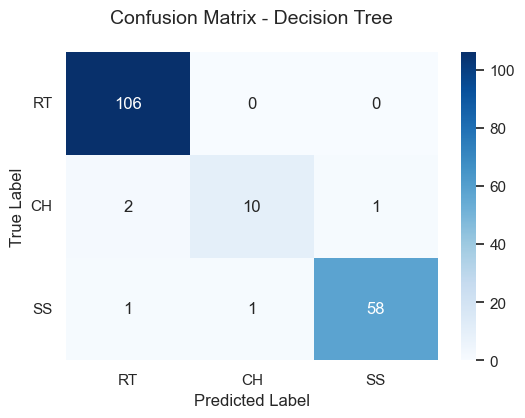

In [75]:
plot_hawk_confusion_matrix(y_test, y_pred)
plt.show()

There are only 5 misclassified cases. The decision tree is able to capture the patterns in the data effectively in general, as indicated by the cell counts.

### Performance/Error Analysis: Model 1B (max_depth=6)

Next, I will fit a decision tree using the same 2 wing/tail length predictors and training data, but with `max_depth=6`. The analysis of model 1A, which has good performance at less complexity already, tells me that this model 1B would be too overfit for the training data, but it will be interesting to see the results and confirm this speculation.

## Model 2: Classification Using 5 Predictors